# GAN training in PyTorch

The `14_gan_training` notebook delves into the process of training Generative Adversarial Networks (GANs), focusing on the practical aspects of setting up and optimizing the training process. It covers preparing the dataset, defining both the Generator and Discriminator models, initializing weights, and setting up loss functions and optimizers. 

The notebook also explores implementing the GAN training loop, visualizing generated samples during training, and monitoring progress. Additionally, it addresses hyperparameter tuning to improve the training results.

## Table of contents

1. [Setting up the environment](#setting-up-the-environment)
2. [Preparing the dataset](#preparing-the-dataset)
3. [Defining the Generator model](#defining-the-generator-model)
4. [Defining the Discriminator model](#defining-the-discriminator-model)
5. [Initializing weights for the GAN](#initializing-weights-for-the-gan)
6. [Defining the loss functions](#defining-the-loss-functions)
7. [Setting up optimizers](#setting-up-optimizers)
8. [Implementing the GAN training loop](#implementing-the-gan-training-loop)
9. [Visualizing generated samples during training](#visualizing-generated-samples-during-training)
10. [Monitoring GAN training progress](#monitoring-gan-training-progress)
11. [Hyperparameter tuning](#hyperparameter-tuning)

## Setting up the environment


##### **Q1: How do you install the necessary libraries for building and training GANs in PyTorch?**


In [160]:
# !pip install torch torchvision matplotlib

##### **Q2: How do you import the required modules for data loading, model building, and GAN training in PyTorch?**


In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

##### **Q3: How do you set up your environment to utilize a GPU, and how do you fallback to a CPU in PyTorch?**


In [162]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##### **Q4: How do you set a random seed in PyTorch to ensure reproducibility when training a GAN?**

In [163]:
manualSeed = 999
torch.manual_seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

## Preparing the dataset


##### **Q5: How do you load an image dataset using PyTorch’s `torchvision.datasets`?**


In [164]:
dataset = torchvision.datasets.SVHN(
    root='./data',
    split='train',
    download=True,
    transform=transforms.ToTensor()
)

Using downloaded and verified file: ./data/train_32x32.mat


##### **Q6: How do you apply image transformations to prepare the dataset for GAN training?**


In [165]:
image_size = 64
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])
dataset = torchvision.datasets.SVHN(
    root='./data',
    split='train',
    download=True,
    transform=transform
)

Using downloaded and verified file: ./data/train_32x32.mat


##### **Q7: How do you create DataLoaders to efficiently load batches of real data for GAN training in PyTorch?**

In [166]:
batch_size = 128
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

## Defining the Generator model


##### **Q8: How do you define the architecture of the Generator model using PyTorch’s `nn.Module`?**


In [167]:
latent_vector_size = 100  # Size of z latent vector
ngf = 64  # Size of feature maps in generator
nc = 3    # Number of channels in the training images (3 for RGB)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, ngf * 8, 4, 1, 0, bias=False),  # Input: Z latent vector
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # State size: (ngf*8) x 4 x 4
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # State size: (ngf*4) x 8 x 8
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # State size: (ngf*2) x 16 x 16
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # State size: (ngf) x 32 x 32
            nn.Tanh()  # Output: (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)

##### **Q9: How do you implement the forward pass of the Generator to output fake images from random noise in PyTorch?**


In [168]:
# See forward pass above

##### **Q10: How do you specify the input latent vector size for the Generator?**

In [169]:
# latent_vector_size is already specified as 100 in the Generator definition

## Defining the Discriminator model


##### **Q11: How do you define the architecture of the Discriminator model using PyTorch’s `nn.Module`?**


In [170]:
ndf = 64  # Size of feature maps in discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # Input: (nc) x 64 x 64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # State size: (ndf) x 32 x 32
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # State size: (ndf*2) x 16 x 16
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # State size: (ndf*4) x 8 x 8
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # State size: (ndf*8) x 4 x 4
            nn.Sigmoid()  # Output: Probability scalar
        )
    def forward(self, input):
        return self.main(input).view(-1)

##### **Q12: How do you implement the forward pass of the Discriminator to classify real and fake data in PyTorch?**


In [171]:
# See forward pass above

##### **Q13: How do you specify the output of the Discriminator to return a probability of whether the input is real or fake?**

In [172]:
# The Discriminator's output layer uses nn.Sigmoid() to return a probability scalar

## Initializing weights for the GAN


##### **Q14: How do you implement a weight initialization function for the Generator and Discriminator in PyTorch?**


In [173]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # Initialize convolutional weights
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)  # Initialize batch norm weights
        nn.init.constant_(m.bias.data, 0)

##### **Q15: How do you apply the custom weight initialization function to both the Generator and Discriminator models after defining them?**

In [174]:
netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Defining the loss functions


##### **Q16: How do you define the loss function for the Discriminator to classify real and fake data in PyTorch?**


In [175]:
criterion = nn.BCELoss()  # Binary Cross Entropy loss

##### **Q17: How do you define the loss function for the Generator to fool the Discriminator in PyTorch?**

In [176]:
# The Generator uses the same BCELoss to fool the Discriminator

## Setting up optimizers


##### **Q18: How do you configure optimizers for both the Generator and Discriminator models in PyTorch?**


In [177]:
lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

##### **Q19: How do you set different learning rates for the Generator and Discriminator models?**

In [178]:
# If needed:
# lrD = 0.0004
# lrG = 0.0001

# optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

## Implementing the GAN training loop


##### **Q20: How do you implement the training loop to update the Discriminator on real and fake data in PyTorch?**


In [179]:
num_epochs = 5  # Adjust the number of epochs as needed
real_label = 1.0
fake_label = 0.0

G_losses = []
D_losses = []
img_list = []
iters = 0

fixed_noise = torch.randn(64, latent_vector_size, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # Update Discriminator with real images:
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Update Discriminator with fake images:
        noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()
        
        # Update Generator to fool Discriminator:
        netG.zero_grad()
        label.fill_(real_label)  # Generator wants Discriminator to label fakes as real
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save losses for plotting later:
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check progress by saving Generator's output on fixed_noise:
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

##### **Q21: How do you implement the training loop to update the Generator so it can fool the Discriminator in PyTorch?**


In [ ]:
# See above

##### **Q22: How do you alternate training between the Discriminator and Generator during each training epoch?**

In [ ]:
# See above

## Visualizing generated samples during training


##### **Q23: How do you generate and visualize fake samples from the Generator after a specific number of epochs?**


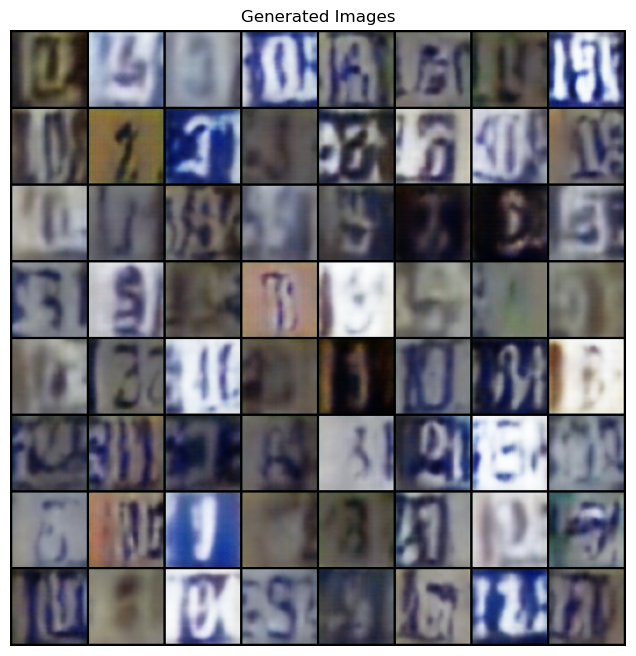

In [180]:
with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1,2,0)))
plt.show()

##### **Q24: How do you compare generated samples to real samples during training to monitor GAN progress?**

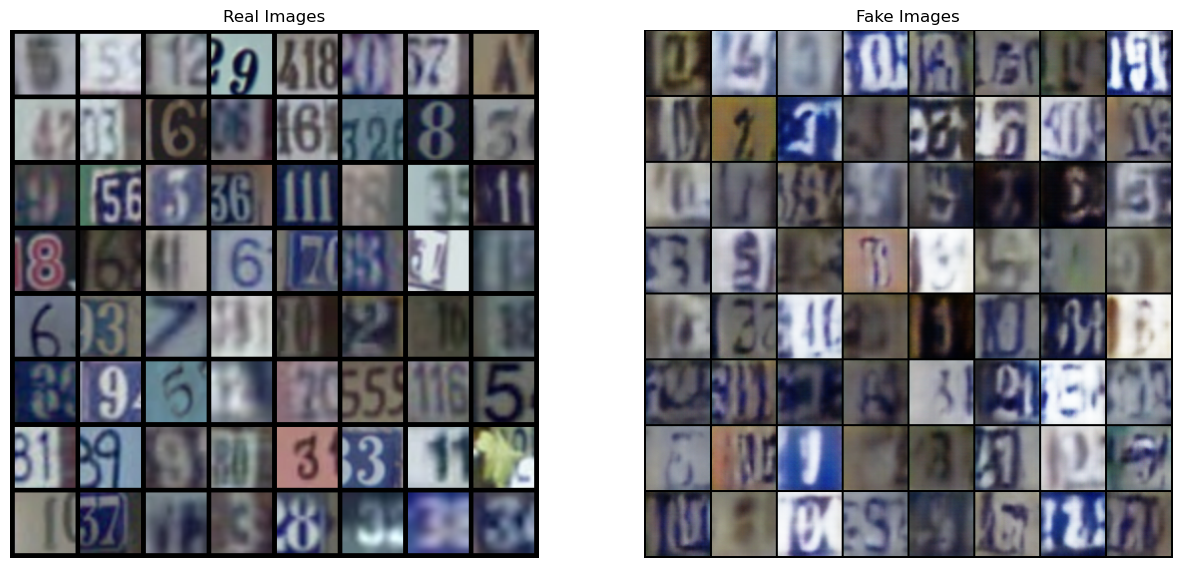

In [195]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))  # Plot Real Images

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))  # Plot Fake Images
plt.show()

## Monitoring GAN training progress


##### **Q25: How do you monitor and log the loss values for both the Generator and Discriminator during GAN training?**


In [187]:
# Already done in the training loop. To check out averages:
from numpy import average

print('Average Generator losses:', average(G_losses))
print('Average Discriminator losses:', average(D_losses))

Average Generator losses: 3.6076273186018537
Average Discriminator losses: 0.7381869878707678


##### **Q26: How do you plot and analyze the loss curves of both the Generator and Discriminator over time?**


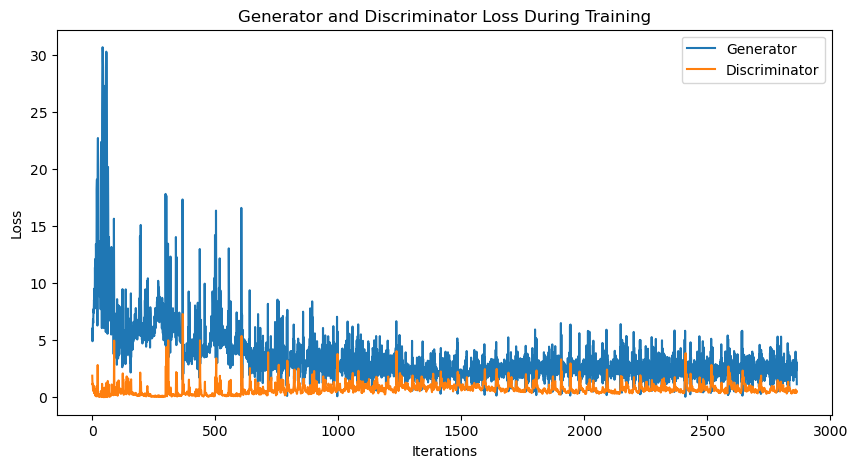

In [188]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

##### **Q27: How do you detect signs of mode collapse or imbalance between the Generator and Discriminator based on the loss values?**

In [189]:
def detect_mode_collapse(G_losses, D_losses, img_list, threshold=0.1):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()  # Plot the Generator and Discriminator losses

    G_losses_np = np.array(G_losses)
    D_losses_np = np.array(D_losses)  # Analyze the loss values

    G_loss_diff = np.abs(np.diff(G_losses_np))
    D_loss_diff = np.abs(np.diff(D_losses_np))  # Calculate the difference between consecutive losses

    if np.mean(G_loss_diff[-100:]) < threshold:  # Check if the Generator loss is decreasing rapidly
        print("Generator loss is not changing significantly, possible mode collapse.")
    else:
        print("Generator loss is changing, likely no mode collapse.")

    if np.mean(D_losses_np[-100:]) < threshold:  # Check if the Discriminator loss is very low
        print("Discriminator loss is very low, Discriminator may be overpowering the Generator.")
    else:
        print("Discriminator loss is within normal range.")

    if len(img_list) >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 15))
        axes[0].imshow(np.transpose(img_list[-1], (1, 2, 0)))
        axes[0].set_title("Generated Images at Iteration {}".format(len(G_losses)))
        axes[0].axis("off")

        axes[1].imshow(np.transpose(img_list[-2], (1, 2, 0)))
        axes[1].set_title("Generated Images at Iteration {}".format(len(G_losses) - 1))
        axes[1].axis("off")

        plt.show()  # Visualize the diversity of generated images

        image_difference = torch.abs(img_list[-1] - img_list[-2]).mean().item()  # Compare the two images
        if image_difference < threshold:
            print("Generated images are very similar, indicating possible mode collapse.")
        else:
            print("Generated images show diversity.")
    else:
        print("Not enough images to compare for mode collapse.")

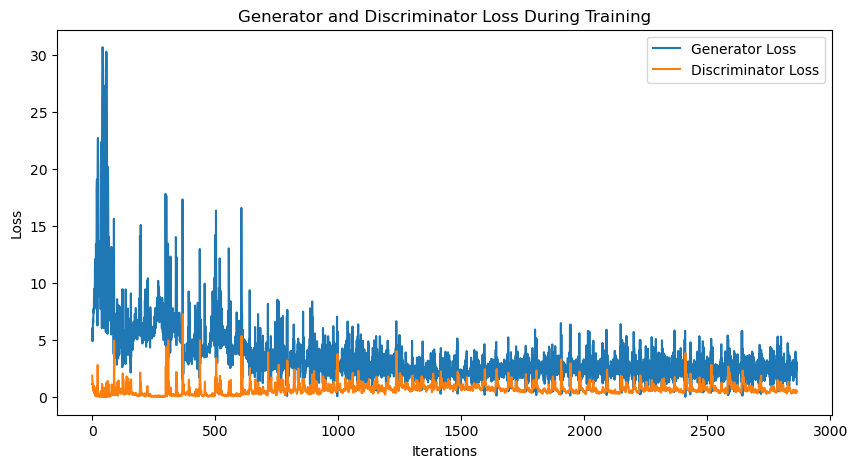

Generator loss is changing, likely no mode collapse.
Discriminator loss is within normal range.


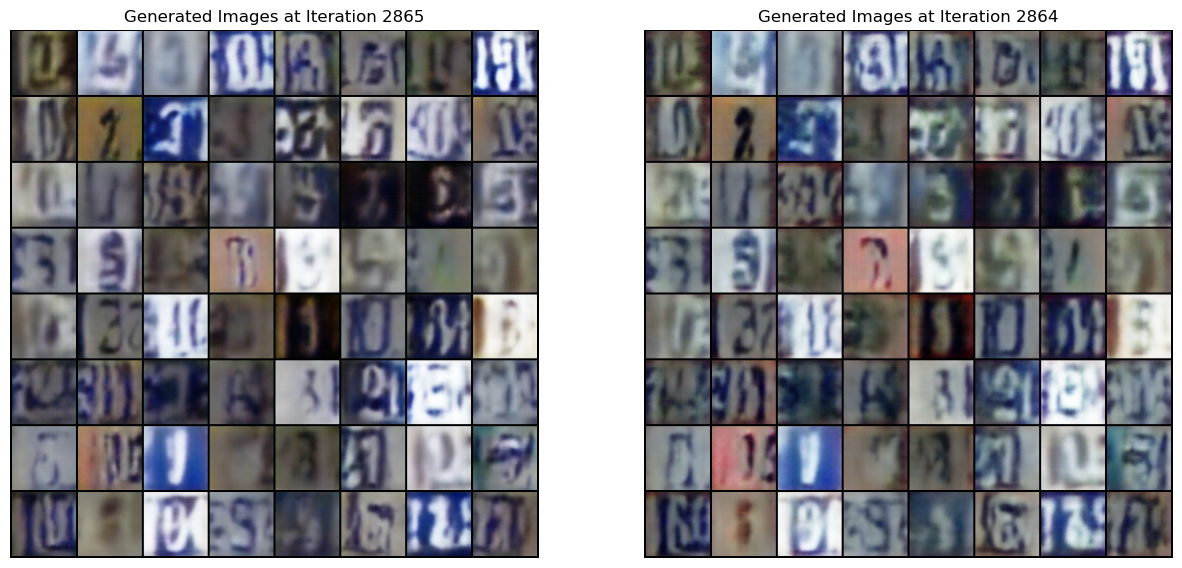

Generated images are very similar, indicating possible mode collapse.


In [196]:
detect_mode_collapse(G_losses, D_losses, img_list)

## Hyperparameter tuning


##### **Q28: How do you adjust the batch size and observe its impact on GAN training stability and performance?**


In [197]:
def train_gan_batch_size(batch_size, num_epochs=5):
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    netG = Generator().to(device)
    netG.apply(weights_init)

    netD = Discriminator().to(device)
    netD.apply(weights_init)

    criterion = nn.BCELoss()

    lr = 0.0002
    beta1 = 0.5
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    real_label = 1.0
    fake_label = 0.0

    G_losses = []
    D_losses = []
    img_list = []
    iters = 0

    fixed_noise = torch.randn(64, latent_vector_size, 1, 1, device=device)

    print(f"Starting Training with Batch Size: {batch_size}")

    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            netD.zero_grad()
            real_images = data[0].to(device)
            b_size = real_images.size(0)
            label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
            output = netD(real_images)
            errD_real = criterion(output, label)
            errD_real.backward()

            noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(fake_label)
            output = netD(fake_images.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake_images)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()

            G_losses.append(errG.item())
            D_losses.append(errD.item())

            if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    plt.figure(figsize=(10, 5))
    plt.title(f"Losses During Training with Batch Size {batch_size}")
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return G_losses, D_losses, img_list

Starting Training with Batch Size: 4


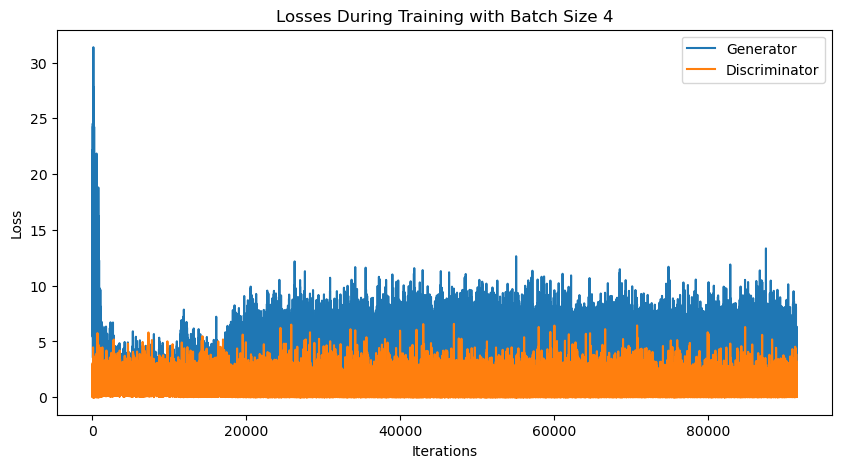

Starting Training with Batch Size: 8


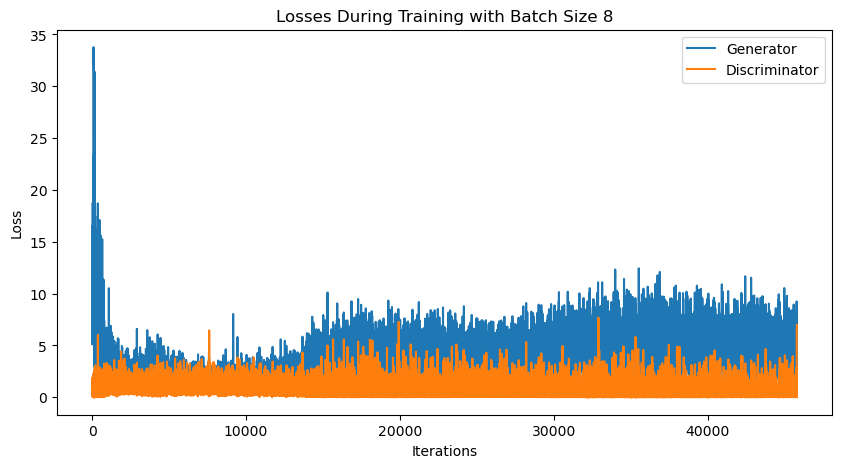

Starting Training with Batch Size: 16


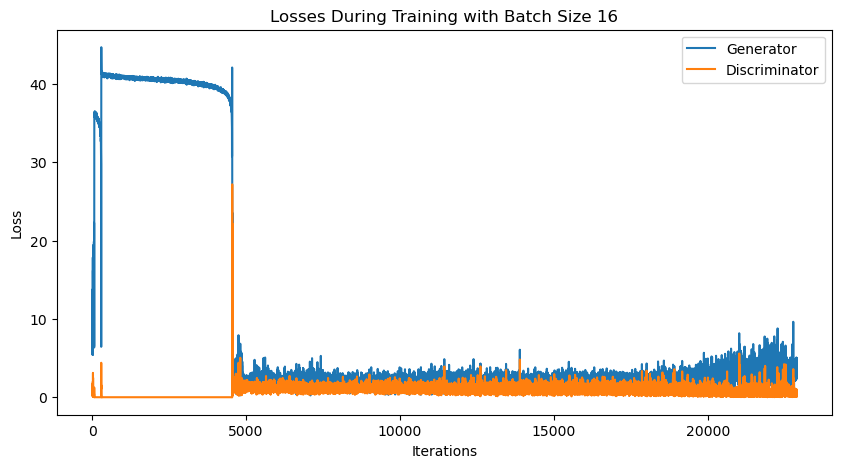

In [198]:
for bs in [4, 8, 16]:
    G_losses, D_losses, img_list = train_gan_batch_size(batch_size=bs, num_epochs=5)

##### **Q29: How do you experiment with different learning rates for the Generator and Discriminator to optimize training?**


In [199]:
def train_gan_learning_rates(lrD, lrG, num_epochs=5):
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    netG = Generator().to(device)
    netG.apply(weights_init)

    netD = Discriminator().to(device)
    netD.apply(weights_init)

    criterion = nn.BCELoss()

    beta1 = 0.5
    optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

    real_label = 1.0
    fake_label = 0.0

    G_losses = []
    D_losses = []
    img_list = []
    iters = 0

    fixed_noise = torch.randn(64, latent_vector_size, 1, 1, device=device)

    print(f"Starting Training with lrD: {lrD}, lrG: {lrG}")

    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            netD.zero_grad()
            real_images = data[0].to(device)
            b_size = real_images.size(0)
            label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
            output = netD(real_images)
            errD_real = criterion(output, label)
            errD_real.backward()

            noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(fake_label)
            output = netD(fake_images.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake_images)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()

            G_losses.append(errG.item())
            D_losses.append(errD.item())

            if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    plt.figure(figsize=(10, 5))
    plt.title(f"Losses During Training with lrD: {lrD}, lrG: {lrG}")
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return G_losses, D_losses, img_list

Starting Training with lrD: 0.0002, lrG: 0.0002


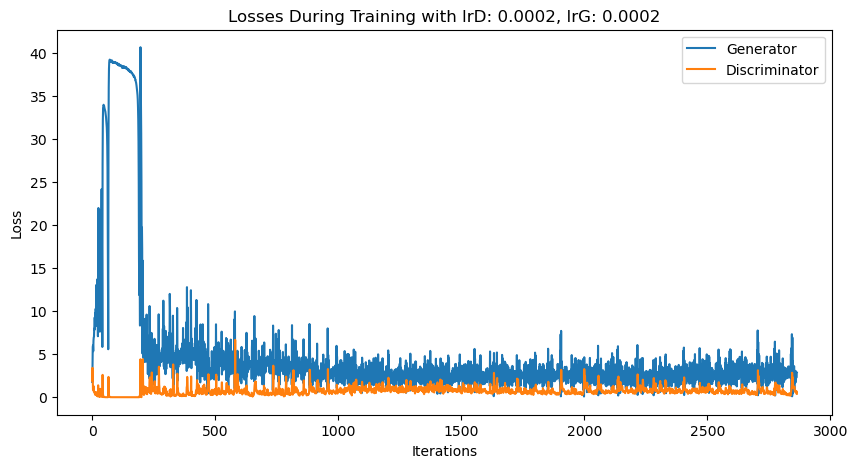

Starting Training with lrD: 0.0001, lrG: 0.0004


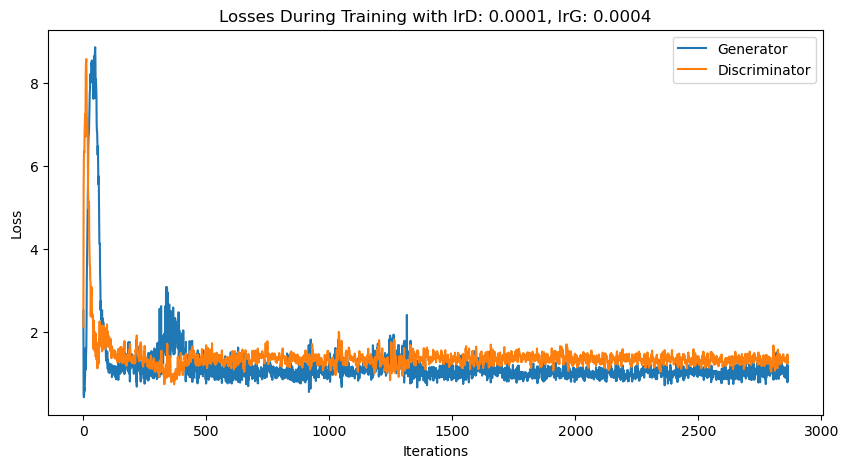

Starting Training with lrD: 0.0004, lrG: 0.0001


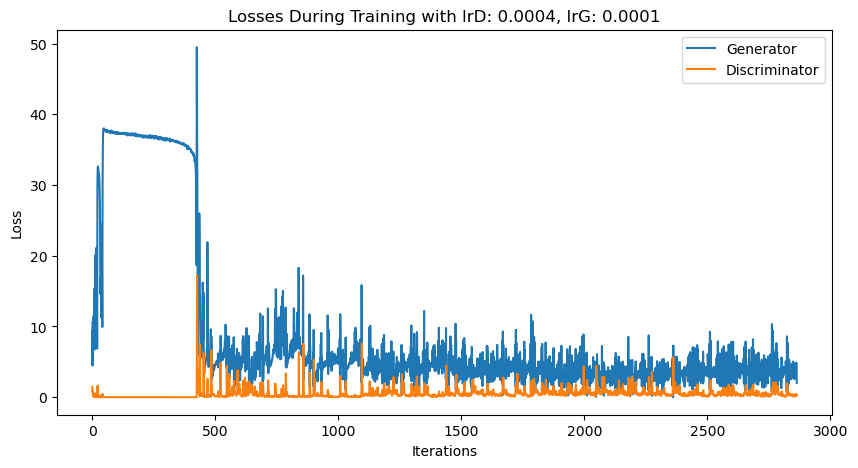

In [200]:
learning_rates = [(0.0002, 0.0002), (0.0001, 0.0004), (0.0004, 0.0001)]
for lrD, lrG in learning_rates:
    G_losses, D_losses, img_list = train_gan_learning_rates(lrD=lrD, lrG=lrG, num_epochs=5)

##### **Q30: How do you modify the number of training epochs to find the optimal stopping point for GAN training?**

In [201]:
def train_gan_epochs(num_epochs, batch_size=128):
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    netG = Generator().to(device)
    netG.apply(weights_init)

    netD = Discriminator().to(device)
    netD.apply(weights_init)

    criterion = nn.BCELoss()

    lr = 0.0002
    beta1 = 0.5
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    real_label = 1.0
    fake_label = 0.0

    G_losses = []
    D_losses = []
    img_list = []
    iters = 0

    fixed_noise = torch.randn(64, latent_vector_size, 1, 1, device=device)

    print(f"Starting Training for {num_epochs} Epochs")

    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):

            netD.zero_grad()
            real_images = data[0].to(device)
            b_size = real_images.size(0)
            label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
            output = netD(real_images)
            errD_real = criterion(output, label)
            errD_real.backward()

            noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(fake_label)
            output = netD(fake_images.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake_images)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()

            G_losses.append(errG.item())
            D_losses.append(errD.item())

            if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    plt.figure(figsize=(10, 5))
    plt.title(f"Losses During Training for {num_epochs} Epochs")
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return G_losses, D_losses, img_list

Starting Training for 5 Epochs


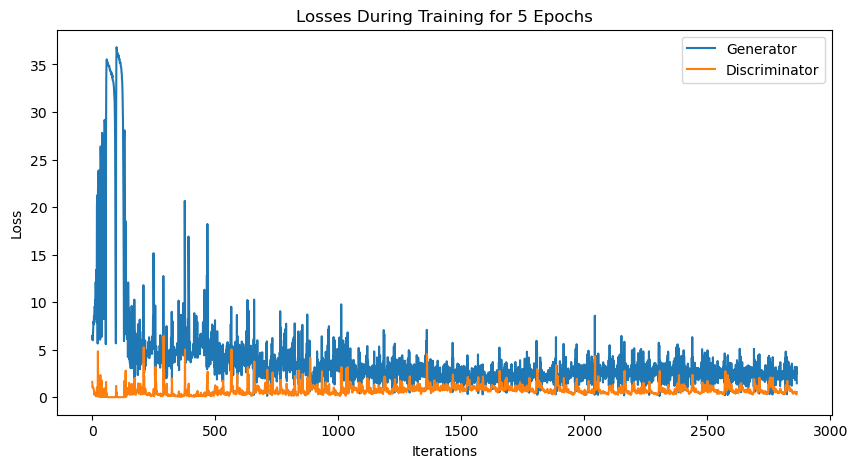

Starting Training for 10 Epochs


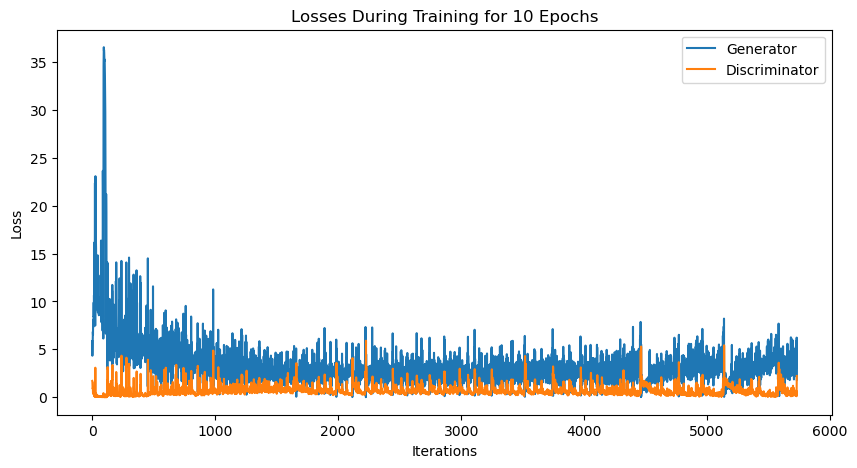

Starting Training for 25 Epochs


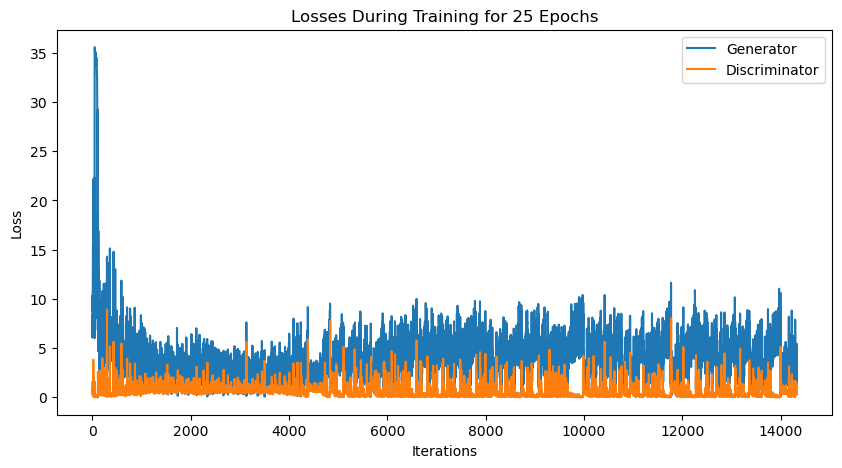

In [202]:
for epochs in [5, 10, 25]:
    G_losses, D_losses, img_list = train_gan_epochs(num_epochs=epochs, batch_size=128)

In [203]:
import shutil
import os

if os.path.exists('data'):
    shutil.rmtree('data')
    print("Folder 'data' has been deleted.")
else:
    print("Folder 'data' does not exist.")

Folder 'data' has been deleted.
